## 导入必要的安装包

In [1]:
!pip install tushare
!pip install tqdm
!pip install openpyxl
import pandas as pd
import numpy as np
import tushare as ts
import os
from tqdm import tqdm
import glob
ts.set_token('ce1d8f98f48f0c92fa70a66528612510f350b82ea565bc1abd45b5ac')
debug = False
from datetime import datetime
pro = ts.pro_api()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 9.7 MB/s eta 0:00:00


## 生成Alpha因子的基础函数

In [2]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1


## 一系列Alpha因子

In [3]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap']
        self.volume = daily_info['volume']
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
#         alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
#         alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
#         alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
#         alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
#         alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
#         alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
#         alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
#         alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
#         alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
#         alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
#         alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
#         alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close

#         tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
#         alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
#         alpha_dict['alpha30']=tmp2/delay(tmp2,4)

#         tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
#         alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

#         tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
#         alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)

#         alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
#         alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
#         alpha_dict['alpha_total_mv']= daily_info['total_mv']
#         alpha_dict['alpha_pb']= -1*daily_info['pb']
#         alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
#         alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
#         alpha_dict['alpha_vwap']= daily_info['vwap']
#         alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']

        alpha_dict['open'] = daily_info['open']
        alpha_dict['high'] = daily_info['high']
        alpha_dict['low'] = daily_info['low']
        alpha_dict['close'] = daily_info['close']
#         alpha_dict['vwap'] = daily_info['vwap']
        alpha_dict['volume'] = daily_info['volume']
#         alpha_dict['amount'] = daily_info['amount']

        return alpha_dict


## 生成训练集

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# pro = ts.pro_api()
# all_stock = pro.stock_basic()
# price_PD_total = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/price_PD.csv', dtype = {'trade_date': 'str'})
# price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
# all_stock = all_stock[['ts_code','name','market','industry']]
# price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
# price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
#        'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
# price_PD_total = price_PD_total[price_PD_total.market.isin(['创业板'])]
# price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

from google.colab import drive
drive.mount('/content/drive')

pro = ts.pro_api()
all_stock = pro.stock_basic()
price_PD_total = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = all_stock[['ts_code','name','market','industry']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

Mounted at /content/drive


In [6]:
price_PD_total

,ts_code,name,market,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,平安银行,主板,银行,20190102,9.39,9.42,9.16,9.19,9.38,-0.19,-2.0256,539386.32,498695.109
1,000001.SZ,平安银行,主板,银行,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707
2,000001.SZ,平安银行,主板,银行,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888
3,000001.SZ,平安银行,主板,银行,20190107,9.84,9.85,9.63,9.74,9.75,-0.01,-0.1026,865687.66,841166.430
4,000001.SZ,平安银行,主板,银行,20190108,9.73,9.74,9.62,9.66,9.74,-0.08,-0.8214,402388.11,389247.795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638017,605599.SH,菜百股份,主板,服饰,20250122,10.82,10.93,10.68,10.90,10.81,0.09,0.8326,23283.75,25166.036
5638018,605599.SH,菜百股份,主板,服饰,20250123,10.94,11.01,10.90,10.92,10.90,0.02,0.1835,20995.32,23006.947
5638019,605599.SH,菜百股份,主板,服饰,20250124,10.90,11.06,10.81,11.06,10.92,0.14,1.2821,23710.36,26041.582
5638020,605599.SH,菜百股份,主板,服饰,20250127,11.07,11.34,11.07,11.24,11.06,0.18,1.6275,32911.00,37024.684


In [ ]:
# price_PD_total.iloc[30000:30020]

In [7]:
ss = price_PD_total.groupby('ts_code')['close'].count()
len(ss[ss==1475].index.tolist())
# len(ss.index.to_list())
# ss

2258

In [8]:
ss[ss==1475]

,close
ts_code,
000001.SZ,1475
000002.SZ,1475
000006.SZ,1475
000008.SZ,1475
000009.SZ,1475
...,...
603987.SH,1475
603989.SH,1475
603993.SH,1475


In [9]:
ss_2 = price_PD_total.groupby('market')['close'].count()
ss_2

,close
market,
主板,4160157
创业板,1477865


In [10]:
ss_3 = price_PD_total.groupby('trade_date')['close'].count()
ss_3

,close
trade_date,
20190102,3190
20190103,3191
20190104,3191
20190107,3190
20190108,3193
...,...
20250122,4347
20250123,4349
20250124,4347


In [11]:
price_PD_total = price_PD_total[price_PD_total.ts_code.isin(ss[ss==1475].index.tolist())]

In [12]:
price_PD_total.ts_code.nunique()

2258

In [13]:

daily_basic = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/daily_basic.csv', dtype = {'trade_date': 'str'})
daily_basic

,ts_code,trade_date,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,000001.SZ,20190102,0.3141,0.7088,0.99,6.8048,6.4428,0.7330,1.4917,1.4012,1.4799,1.4799,1.717041e+06,1.717025e+06,761029.0923,1.577961e+07,1.577946e+07
1,000001.SZ,20190103,0.2420,0.5460,0.76,6.8714,6.5059,0.7402,1.5063,1.4149,1.4655,1.4655,1.717041e+06,1.717025e+06,761029.0923,1.593414e+07,1.593399e+07
2,000001.SZ,20190104,0.8626,1.9463,2.87,7.2194,6.7456,0.7607,1.5825,1.4343,1.3949,1.3949,1.717041e+06,1.717025e+06,761029.0923,1.674115e+07,1.674099e+07
3,000001.SZ,20190107,0.5042,1.1375,1.19,7.2120,6.7386,0.7599,1.5809,1.4329,1.3963,1.3963,1.717041e+06,1.717025e+06,761029.0923,1.672398e+07,1.672382e+07
4,000001.SZ,20190108,0.2344,0.5287,0.52,7.1528,6.6833,0.7536,1.5679,1.4211,1.4079,1.4079,1.717041e+06,1.717025e+06,761029.0923,1.658662e+07,1.658646e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718158,920128.BJ,20250122,5.5613,5.5613,0.87,50.1866,48.6791,4.2442,3.9764,3.7950,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.277380e+05,4.796550e+04
6718159,920128.BJ,20250123,5.8266,5.8266,1.02,49.9898,48.4882,4.2276,3.9608,3.7802,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.268449e+05,4.777740e+04
6718160,920128.BJ,20250124,3.9659,3.9659,0.74,49.7393,48.2453,4.2064,3.9409,3.7612,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.257082e+05,4.753800e+04
6718161,920128.BJ,20250127,3.0706,3.0706,0.61,49.6856,48.1932,4.2018,3.9367,3.7572,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.254646e+05,4.748670e+04


In [14]:
price_PD_total = pd.merge(price_PD_total,daily_basic,how='left',on=['ts_code','trade_date'])


In [16]:
price_PD_total.head(5)

,ts_code,name,market,industry,trade_date,open,high,low,close,pre_close,...,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,000001.SZ,平安银行,主板,银行,20190102,9.39,9.42,9.16,9.19,9.38,...,0.7330,1.4917,1.4012,1.4799,1.4799,1.717041e+06,1.717025e+06,761029.0923,1.577961e+07,1.577946e+07
1,000001.SZ,平安银行,主板,银行,20190103,9.18,9.33,9.15,9.28,9.19,...,0.7402,1.5063,1.4149,1.4655,1.4655,1.717041e+06,1.717025e+06,761029.0923,1.593414e+07,1.593399e+07
2,000001.SZ,平安银行,主板,银行,20190104,9.24,9.82,9.22,9.75,9.28,...,0.7607,1.5825,1.4343,1.3949,1.3949,1.717041e+06,1.717025e+06,761029.0923,1.674115e+07,1.674099e+07
3,000001.SZ,平安银行,主板,银行,20190107,9.84,9.85,9.63,9.74,9.75,...,0.7599,1.5809,1.4329,1.3963,1.3963,1.717041e+06,1.717025e+06,761029.0923,1.672398e+07,1.672382e+07
4,000001.SZ,平安银行,主板,银行,20190108,9.73,9.74,9.62,9.66,9.74,...,0.7536,1.5679,1.4211,1.4079,1.4079,1.717041e+06,1.717025e+06,761029.0923,1.658662e+07,1.658646e+07


In [ ]:
len(price_PD_total.columns)

29

In [ ]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [ ]:

#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0)
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1)
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [ ]:

daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='open')
daily_info['close'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='close')
daily_info['high']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='high')
daily_info['low']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='low')
daily_info['volume']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='vol')
daily_info['amount']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1)


In [ ]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [ ]:
alpha_dict.keys()

dict_keys(['open', 'high', 'low', 'close', 'volume'])

In [ ]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


In [ ]:
v = alpha_dict['open']
v

ts_code,000001.SZ,000002.SZ,000006.SZ,000008.SZ,000009.SZ,000011.SZ,000012.SZ,000014.SZ,000019.SZ,000020.SZ,...,603970.SH,603976.SH,603978.SH,603979.SH,603980.SH,603987.SH,603989.SH,603993.SH,603998.SH,603999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20190102,9.39,23.83,5.18,3.89,4.35,9.20,3.99,9.29,7.16,10.52,...,15.47,16.40,18.85,7.50,11.79,6.46,20.64,3.78,4.68,4.86
20190103,9.18,23.79,5.15,3.87,4.28,9.31,4.00,9.52,7.10,10.31,...,14.74,16.79,19.04,7.35,11.78,6.44,19.53,3.70,4.56,4.79
20190104,9.24,23.91,5.09,3.80,4.20,9.26,4.01,9.31,7.00,10.18,...,14.00,16.81,18.72,7.30,11.62,6.38,18.67,3.68,4.55,4.70
20190107,9.84,25.29,5.35,3.95,4.43,9.69,4.10,9.78,7.28,10.81,...,14.47,17.33,19.82,7.55,11.99,6.73,19.39,3.86,4.75,5.00
20190108,9.73,25.05,5.36,4.07,4.46,9.71,4.12,9.90,7.31,10.89,...,14.57,18.00,19.81,7.55,12.10,6.63,19.63,3.90,4.91,5.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250122,11.32,7.27,7.10,2.61,8.64,8.50,4.90,10.30,6.29,12.99,...,14.03,15.90,13.47,41.54,4.24,7.18,16.34,7.07,9.61,5.94
20250123,11.17,7.15,7.16,2.59,8.65,8.13,4.93,10.14,6.32,12.86,...,13.98,16.04,13.62,41.25,4.26,7.18,16.39,7.22,9.81,5.96
20250124,11.32,7.33,6.89,2.57,8.54,8.03,4.95,10.09,6.32,12.78,...,13.79,15.78,13.44,40.31,4.21,7.14,15.95,7.17,9.65,5.92


In [ ]:
tmp = v.unstack()
tmp

ts_code    trade_date
000001.SZ  20190102      9.39
           20190103      9.18
           20190104      9.24
           20190107      9.84
           20190108      9.73
                         ... 
603999.SH  20250122      5.94
           20250123      5.96
           20250124      5.92
           20250127      6.10
           20250205      6.21
Length: 3330550, dtype: float64

In [ ]:
tmp.reset_index()

,ts_code,trade_date,0
0,000001.SZ,20190102,9.39
1,000001.SZ,20190103,9.18
2,000001.SZ,20190104,9.24
3,000001.SZ,20190107,9.84
4,000001.SZ,20190108,9.73
...,...,...,...
3330545,603999.SH,20250122,5.94
3330546,603999.SH,20250123,5.96
3330547,603999.SH,20250124,5.92
3330548,603999.SH,20250127,6.10


In [ ]:
tmp.reset_index().rename(columns={0:'open'})

,ts_code,trade_date,open
0,000001.SZ,20190102,9.39
1,000001.SZ,20190103,9.18
2,000001.SZ,20190104,9.24
3,000001.SZ,20190107,9.84
4,000001.SZ,20190108,9.73
...,...,...,...
3330545,603999.SH,20250122,5.94
3330546,603999.SH,20250123,5.96
3330547,603999.SH,20250124,5.92
3330548,603999.SH,20250127,6.10


In [ ]:
data.head(5)

,ts_code,trade_date,open,high,low,close,volume
0,000001.SZ,20190102,9.39,9.42,9.16,9.19,539386.32
1,000001.SZ,20190103,9.18,9.33,9.15,9.28,415537.95
2,000001.SZ,20190104,9.24,9.82,9.22,9.75,1481159.06
3,000001.SZ,20190107,9.84,9.85,9.63,9.74,865687.66
4,000001.SZ,20190108,9.73,9.74,9.62,9.66,402388.11


In [ ]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [ ]:
data.head(5)

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up
0,000001.SZ,20190102,9.39,9.42,9.16,9.19,539386.32,平安银行,1.009793,1.062092,1.062092,NaN
1,000001.SZ,20190103,9.18,9.33,9.15,9.28,415537.95,平安银行,1.050647,1.054113,1.054113,1.011853
2,000001.SZ,20190104,9.24,9.82,9.22,9.75,1481159.06,平安银行,0.998974,0.981707,0.981707,0.941538
3,000001.SZ,20190107,9.84,9.85,9.63,9.74,865687.66,平安银行,0.991786,1.021583,1.021583,0.948665
4,000001.SZ,20190108,9.73,9.74,9.62,9.66,402388.11,平安银行,1.028986,1.036961,1.036961,1.018634


In [ ]:
len(data)

3330550

In [ ]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'industry', 'trade_date', 'open', 'high',
       'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount',
       'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe', 'pe_ttm',
       'pb', 'ps', 'ps_ttm', 'dv_ratio', 'dv_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'open_up', 'ret1',
       'ret2', 'ret'],
      dtype='object')

In [ ]:
data = data[~data.close.isna()].reset_index(drop=True)
len(data)

3330550

In [ ]:
train = data.copy()
# train = train[train.trade_date < '20240101']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

# from sklearn.model_selection import KFold,GroupKFold,train_test_split

# kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

# enumsplit = []
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind, val_ind])
# enumsplit

In [ ]:
len(train)

3326034

In [ ]:
train.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'volume',
       'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [ ]:
# features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
#        'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
#        'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
#        'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
#        'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
#        'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
#        'alpha_dv_ttm']

features = ['open', 'high', 'low', 'close', 'volume']


In [ ]:
train.head()

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,000001.SZ,20190102,9.39,9.42,9.16,9.19,539386.32,平安银行,1.009793,1.062092,1.062092,NaN,0.925155
1,000001.SZ,20190103,9.18,9.33,9.15,9.28,415537.95,平安银行,1.050647,1.054113,1.054113,1.011853,0.538530
2,000001.SZ,20190104,9.24,9.82,9.22,9.75,1481159.06,平安银行,0.998974,0.981707,0.981707,0.941538,0.067316
3,000001.SZ,20190107,9.84,9.85,9.63,9.74,865687.66,平安银行,0.991786,1.021583,1.021583,0.948665,0.862932
4,000001.SZ,20190108,9.73,9.74,9.62,9.66,402388.11,平安银行,1.028986,1.036961,1.036961,1.018634,0.937998


In [ ]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())


In [ ]:
# test = data.copy()
# test = test[test.trade_date > '20230101']
# test.replace([np.inf, -np.inf], np.nan,inplace=True)
# test[features] = test[features].fillna(train[features].mean())


In [ ]:
# from sklearn.preprocessing import QuantileTransformer

# train_nn=train[features].copy()
# test_nn=test[features].copy()
# qt_train = []
# for col in features:
#     qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
#     train_nn[col] = qt.fit_transform(train_nn[[col]])
#     test_nn[col] = qt.transform(test_nn[[col]])
#     qt_train.append(qt)

In [ ]:
y = train['ret_rank']

In [ ]:
train.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'volume',
       'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 示例DataFrame结构：['stock_id', 'date', 'factor1', 'factor2', ..., 'future_return']
# 假设df已经加载并准备好了

# 数据预处理
# 1. 特征标准化
df = train.copy()
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df, verbose=True)

Memory usage after optimization is: 139.57 MB
Decreased by 57.7%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326034 entries, 0 to 3326033
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ts_code     object 
 1   trade_date  object 
 2   open        float16
 3   high        float16
 4   low         float16
 5   close       float16
 6   volume      float16
 7   name        object 
 8   ret1        float16
 9   ret2        float16
 10  ret         float16
 11  open_up     float16
 12  ret_rank    float16
dtypes: float16(10), object(3)
memory usage: 139.6+ MB


In [ ]:
# 2. 数据转换为时间序列格式
def create_time_series(df, n_steps):
    X, y, Xmeta = [], [], []
    for tmp in tqdm(df.groupby('ts_code')):
        ts_code = tmp[0]
        stock_df = tmp[1]
#         stock_df = df[df['ts_code'] == stock_id]
        for i in range(n_steps-1, len(stock_df)-1):
            X.append(stock_df[feature_columns].iloc[i-n_steps+1:i+1].values)
            y.append(stock_df['ret_rank'].iloc[i])
            Xmeta.append(([ts_code,stock_df['trade_date'].iloc[i]]))
#         break
    return np.array(X), np.array(y), np.array(Xmeta)
feature_columns = features
n_steps = 10  # 使用过去10个时间点的数据
X, y, Xmeta = create_time_series(df, n_steps)

100%|██████████| 2258/2258 [26:19<00:00,  1.43it/s]


In [ ]:
X[0]

array([[-0.1863, -0.191 , -0.1866, -0.1912,  0.8125],
       [-0.1912, -0.1931, -0.1869, -0.1891,  0.524 ],
       [-0.1897, -0.1819, -0.1852, -0.1781,  3.006 ],
       [-0.1758, -0.1812, -0.1755, -0.1783,  1.572 ],
       [-0.1783, -0.1837, -0.1758, -0.1802,  0.4932],
       [-0.1781, -0.1759, -0.1738, -0.1736,  2.43  ],
       [-0.175 , -0.1732, -0.17  , -0.1699,  2.053 ],
       [-0.1694, -0.1727, -0.1655, -0.1676,  1.178 ],
       [-0.1669, -0.172 , -0.165 , -0.1697,  0.7217],
       [-0.1694, -0.1714, -0.1646, -0.1666,  0.819 ]], dtype=float16)

In [ ]:
y[0]

np.float16(0.783)

In [ ]:
Xmeta

array([['000001.SZ', '20190115'],
       ['000001.SZ', '20190116'],
       ['000001.SZ', '20190117'],
       ...,
       ['603999.SH', '20250121'],
       ['603999.SH', '20250122'],
       ['603999.SH', '20250123']], dtype='<U9')

In [ ]:
Xmetapd = pd.DataFrame(Xmeta,columns = ['ts_code','trade_date'])
Xmetapd[Xmetapd.trade_date<'20230101'].index

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
       3302944, 3302945, 3302946, 3302947, 3302948, 3302949, 3302950, 3302951,
       3302952, 3302953],
      dtype='int64', length=2174454)

In [ ]:
# 3. 划分训练集和测试集
trainindex = Xmetapd[Xmetapd.trade_date<'20230101'].index
testindex = Xmetapd[Xmetapd.trade_date>'20230101'].index

X_train, X_test = X[trainindex], X[testindex]
y_train, y_test = y[trainindex], y[testindex]


In [ ]:



# 构建LSTM模型
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, len(feature_columns))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X, y, epochs=2, batch_size=32)

# 预测
predictions = model.predict(X_test)

# 评估模型（这里仅为示例，实际应用中应使用更合适的评估指标）
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
103233/103233 ━━━━━━━━━━━━━━━━━━━━ 537s 5ms/step - loss: 0.0839
Epoch 2/2
103233/103233 ━━━━━━━━━━━━━━━━━━━━ 534s 5ms/step - loss: 0.0832
35282/35282 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
Test MSE: 0.0832262933254242


In [ ]:
len(predictions)

1129000

## 分组法测有效性

In [ ]:
test = Xmetapd[Xmetapd.trade_date>'20230101']
test

,ts_code,trade_date
963,000001.SZ,20230103
964,000001.SZ,20230104
965,000001.SZ,20230105
966,000001.SZ,20230106
967,000001.SZ,20230109
...,...,...
3303449,603999.SH,20250117
3303450,603999.SH,20250120
3303451,603999.SH,20250121
3303452,603999.SH,20250122


In [ ]:
test = pd.merge(test,df,how='left',on=['ts_code','trade_date'])

In [ ]:
test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,000001.SZ,20230103,-0.097290,-0.089294,-0.094421,-0.084290,4.667969,平安银行,1.040039,1.056641,1.056641,0.946777,0.937988
1,000001.SZ,20230104,-0.085388,-0.076233,-0.080688,-0.071411,4.656250,平安银行,1.010742,1.015625,1.015625,0.921875,0.743652
2,000001.SZ,20230105,-0.069275,-0.068848,-0.063110,-0.067688,3.435547,平安银行,1.009766,1.020508,1.020508,0.946777,0.808105
3,000001.SZ,20230106,-0.066956,-0.069336,-0.060516,-0.064453,2.341797,平安银行,1.012695,0.979004,0.979004,0.984863,0.116455
4,000001.SZ,20230109,-0.061096,-0.065674,-0.059570,-0.060211,2.019531,平安银行,0.975586,0.994141,0.994141,0.979492,0.677246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128995,603999.SH,20250117,-0.267578,-0.270508,-0.265381,-0.267578,-0.279297,读者传媒,1.011719,0.993164,0.993164,1.006836,0.436768
1128996,603999.SH,20250120,-0.265381,-0.268066,-0.263672,-0.266113,-0.244751,读者传媒,0.996582,0.978516,0.978516,0.988281,0.463623
1128997,603999.SH,20250121,-0.265137,-0.268555,-0.264648,-0.266602,-0.269287,读者传媒,0.986816,1.000000,1.000000,1.006836,0.691895
1128998,603999.SH,20250122,-0.266846,-0.270508,-0.265137,-0.268311,-0.270996,读者传媒,1.009766,1.021484,1.021484,1.022461,0.873047


In [ ]:
test['pred'] = predictions

In [ ]:
test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank,pred
0,000001.SZ,20230103,-0.097290,-0.089294,-0.094421,-0.084290,4.667969,平安银行,1.040039,1.056641,1.056641,0.946777,0.937988,0.479262
1,000001.SZ,20230104,-0.085388,-0.076233,-0.080688,-0.071411,4.656250,平安银行,1.010742,1.015625,1.015625,0.921875,0.743652,0.476901
2,000001.SZ,20230105,-0.069275,-0.068848,-0.063110,-0.067688,3.435547,平安银行,1.009766,1.020508,1.020508,0.946777,0.808105,0.477325
3,000001.SZ,20230106,-0.066956,-0.069336,-0.060516,-0.064453,2.341797,平安银行,1.012695,0.979004,0.979004,0.984863,0.116455,0.477629
4,000001.SZ,20230109,-0.061096,-0.065674,-0.059570,-0.060211,2.019531,平安银行,0.975586,0.994141,0.994141,0.979492,0.677246,0.478285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128995,603999.SH,20250117,-0.267578,-0.270508,-0.265381,-0.267578,-0.279297,读者传媒,1.011719,0.993164,0.993164,1.006836,0.436768,0.503318
1128996,603999.SH,20250120,-0.265381,-0.268066,-0.263672,-0.266113,-0.244751,读者传媒,0.996582,0.978516,0.978516,0.988281,0.463623,0.501427
1128997,603999.SH,20250121,-0.265137,-0.268555,-0.264648,-0.266602,-0.269287,读者传媒,0.986816,1.000000,1.000000,1.006836,0.691895,0.502599
1128998,603999.SH,20250122,-0.266846,-0.270508,-0.265137,-0.268311,-0.270996,读者传媒,1.009766,1.021484,1.021484,1.022461,0.873047,0.502461


In [ ]:

date_calc = sorted(test.trade_date.unique())



In [ ]:
test = pd.merge(test,all_stock[['ts_code','industry']],how='left',on='ts_code')

test['factor_rank'] = test.groupby(['trade_date','industry']).pred.rank(pct=True,method='dense')

def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [ ]:
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,147000
6,120516
7,118487
3,115503
9,114500
4,109991
8,107006
2,106003
5,104495


<Axes: xlabel='trade_date'>

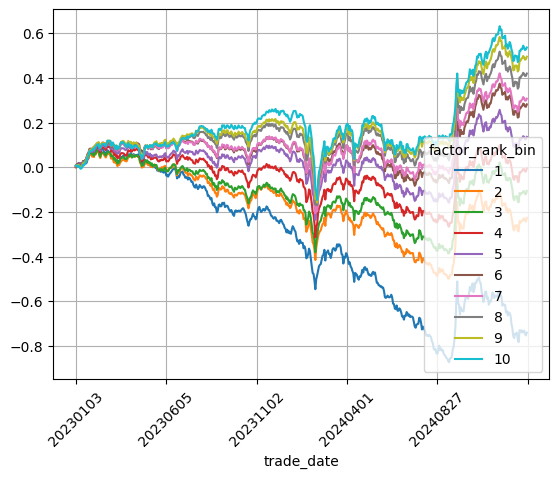

In [ ]:
(test.groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<Axes: xlabel='trade_date'>

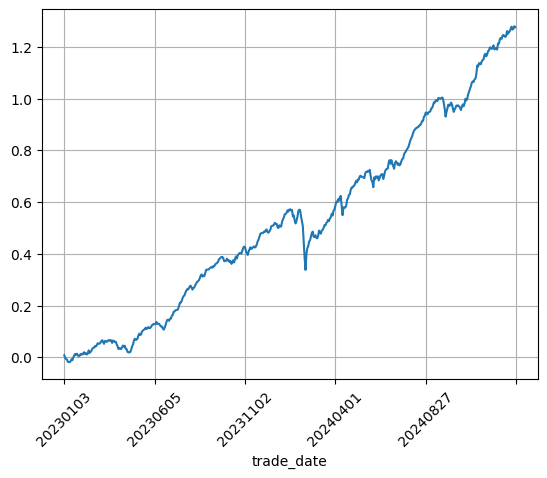

In [ ]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (test[(test.factor_rank_bin == 10)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [ ]:
ret_PD = (test.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [ ]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.372870,-1.425556,0.016477,0.454,-0.883394
1,2,-0.114107,-0.463528,0.015507,0.474,-0.532792
2,3,-0.053432,-0.220340,0.015276,0.492,-0.429698
3,4,-0.002484,-0.010124,0.015454,0.506,-0.373294
4,5,0.068648,0.269677,0.016035,0.512,-0.307438
5,6,0.141936,0.552795,0.016174,0.534,-0.294957
6,7,0.154830,0.591918,0.016478,0.534,-0.301989
7,8,0.211503,0.764605,0.017425,0.552,-0.305983
8,9,0.249492,0.902724,0.017410,0.554,-0.307060
9,10,0.270307,0.956482,0.017802,0.558,-0.322720


## 固定买入N支

<ipython-input-96-9cd31fd94ad7>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2022-2024 year'}, xlabel='trade_date'>

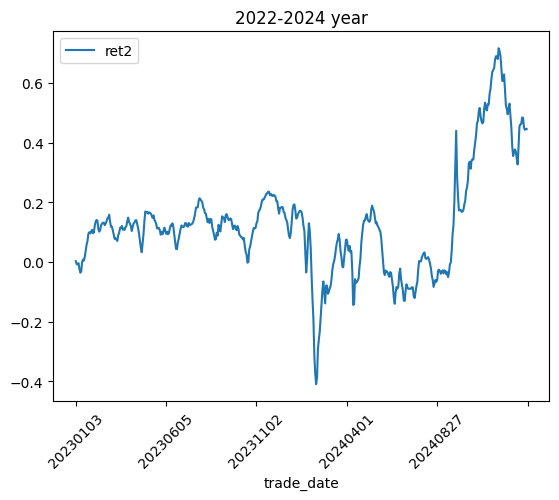

In [ ]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp[~tmp.close.isna()].reset_index(drop=True)
# tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 10
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0005)
(ret_pd1.loc['20220101':,] ).cumsum().plot(rot=45, title = '2022-2024 year')


In [ ]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('trade_date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [ ]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.224668,0.547917,0.02583,0.526,-0.521975


## 对冲收益

In [ ]:
## 计算对冲的收益
dfindex = pro.index_daily(ts_code='000852.SH', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])   #zz1000
# dfindex = pro.index_daily(ts_code='399905.SZ', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])  #zz500
dfindex = dfindex[['trade_date','pct_chg']].set_index('trade_date').sort_index()
dfindex

,pct_chg
trade_date,
20230103,2.2618
20230104,-0.0377
20230105,0.9997
20230106,0.2290
20230109,0.5450
...,...
20250117,0.6941
20250120,0.6433
20250121,0.4911


In [ ]:
ret_pd_concat = pd.merge(ret_pd1,dfindex/100,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','dfindex']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['dfindex']
ret_pd_concat

,ret,dfindex,diff
trade_date,,,
20230103,0.003065,0.022618,-0.019553
20230104,-0.009973,-0.000377,-0.009596
20230105,-0.000793,0.009997,-0.010790
20230106,0.004188,0.002290,0.001898
20230109,-0.018811,0.005450,-0.024261
...,...,...,...
20250117,-0.000646,0.006941,-0.007587
20250120,-0.032434,0.006433,-0.038867
20250121,-0.007531,0.004911,-0.012442


In [ ]:
ret_pd_concat.corr()

,ret,dfindex,diff
ret,1.000000,0.057461,0.834206
dfindex,0.057461,1.000000,-0.502607
diff,0.834206,-0.502607,1.000000


<Axes: title={'center': '2022-2024 year'}, xlabel='trade_date'>

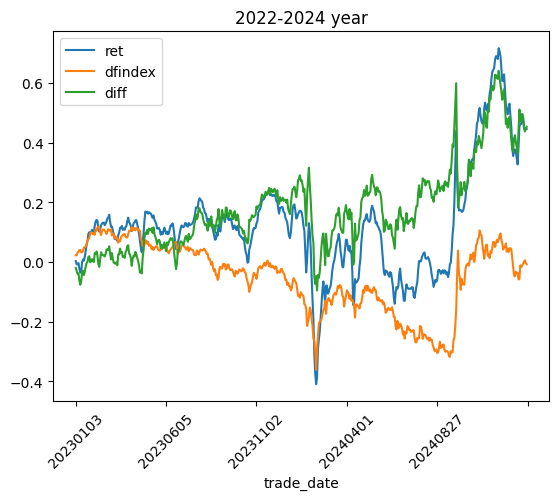

In [ ]:
(ret_pd_concat[['ret','dfindex','diff']].cumsum()).plot(rot=45, title = '2022-2024 year')


In [ ]:
calc_pfmc(ret_pd_concat[['diff']])

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.228456,0.482467,0.029829,0.514,-0.31236
